In [1]:
import pickle, glob
from skimage.io import imread
import numpy as np, glob, tqdm
arrs={f.split('_')[-2]:pickle.load(open(f,'rb')) for f in glob.glob('images/all_*_arrlist.p')}

new_imgs={}
for k in ["aty","neg","squamous","leuk_clusters_deident"]:
    k2=k
    if k.startswith("leuk"): k2="leukocytes"
    new_dat=[imread(img) for img in tqdm.tqdm(glob.glob(f"images/{k}/*.png"))]
    print(k2,len(new_dat),len(arrs[k2]))
    arrs[k2].extend(new_dat)
    

  0%|          | 0/54 [00:00<?, ?it/s]

aty 287 3990


100%|██████████| 54/54 [00:00<00:00, 55.65it/s]


neg 54 4348


100%|██████████| 11072/11072 [05:03<00:00, 36.44it/s]


squamous 11072 3012


100%|██████████| 3341/3341 [01:12<00:00, 46.38it/s]

leukocytes 3341 7642


In [79]:
! ls inputs*/* -lah

-rwxrwx--- 1 f003k8w rc-VaickusL_slow-admin 482M Oct  8 12:22 inputs/train_data.pkl
-rwxrwx--- 1 f003k8w rc-VaickusL_slow-admin 108M Oct  8 12:22 inputs/val_data.pkl
-rwxrwx--- 1 f003k8w rc-VaickusL_slow-admin 1.1G Dec  9 23:57 inputs_new/train_data.pkl
-rwxrwx--- 1 f003k8w rc-VaickusL_slow-admin 264M Dec  9 23:57 inputs_new/val_data.pkl


In [3]:
cell_types=list(arrs.keys())
cell_types.remove("unsorted")

In [ ]:
arrs.keys()

In [4]:
import numpy as np, pandas as pd
X=[]
y=[]
for k in cell_types:
    print(k)
    X.extend(arrs[k])
    y.extend([k]*len(arrs[k]))
y=np.array(y)
X=pd.Series(X)

leukocytes
neg
squamous
aty
rbc
debris
crystal


In [47]:
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances


In [48]:
idxs=np.where(d_mat)

In [56]:
import tqdm,cv2
# can do this instead with hashing, greyscale and downsize for reduced compute time
#     if count==200000: break
X_squam=X[y=='squamous'] # if X is a pandas series containing images for individual elements
shapes_=np.array([x.shape[:2] for x in X_squam]) # get shapes
d_mat=(euclidean_distances(shapes_)+np.eye(len(shapes_))) # coarse shape matching first
d_mat[np.tril_indices(len(d_mat))]=1
d_mat=d_mat==0
same=[]
hashes=X_squam.map(lambda x: cv2.resize(cv2.cvtColor(x,cv2.COLOR_RGB2GRAY),None,fx=1/4,fy=1/4)) # hash to reduce compute time
for i,j in tqdm.tqdm(zip(*idxs),total=d_mat.sum()): # search through all image pairs with matching shapes and look for complete alignment with hashes
    if (hashes.iloc[i]==hashes.iloc[j]).mean()==1:
        same.append((i,j)) # update information on matching images

100%|██████████| 5511820/5511820 [01:37<00:00, 56452.37it/s]


In [77]:
import networkx as nx
G=nx.Graph()
G.add_edges_from(same)
remove=[]
for comp in nx.connected_components(G):
    remove.extend(list(comp)[1:])
hashes.reset_index().iloc[:,1].drop(remove).tolist()[:10]

[array([[255, 255, 255, 240, 205, 232, 255, 255, 255, 255, 251, 192, 131,
         157, 138, 248, 255, 255, 255, 255],
        [255, 255, 228, 207, 174, 173, 166, 195, 187, 192, 194, 214, 223,
         127, 160, 198, 245, 255, 255, 255],
        [239, 207, 206, 203, 191, 203, 197, 206, 195, 203, 176, 191, 177,
         188, 122, 161, 178, 235, 255, 255],
        [228, 218, 215, 214, 215, 221, 220, 193, 197, 194, 130, 190, 168,
          62,  98,  84, 107, 123, 255, 255],
        [255, 223, 206, 223, 217, 212, 218, 201, 207, 178, 194, 198,  89,
          87, 120,  94,  81, 190, 152, 255],
        [255, 237, 213, 221, 221, 217, 213, 223, 205, 192, 202, 161, 128,
         101, 111, 112, 106, 201, 166, 173],
        [255, 247, 219, 183, 223, 203, 209, 198, 216, 213, 201, 223, 226,
          98, 105, 190, 205, 197, 192, 152],
        [255, 255, 255, 226, 218, 229, 206, 204, 203, 188, 204, 191, 202,
         206, 216, 202, 179, 214, 163, 133],
        [255, 255, 255, 245, 220, 214, 215, 209,

In [5]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y2=le.fit_transform(y)

In [6]:
le.classes_

array(['aty', 'crystal', 'debris', 'leukocytes', 'neg', 'rbc', 'squamous'],
      dtype='<U10')

In [60]:
from PIL import Image
Image.fromarray(X.iloc[0])

In [61]:
shapes=np.array(X.map(lambda x: x.shape).tolist())

In [62]:
shapes.shape

(127167, 3)

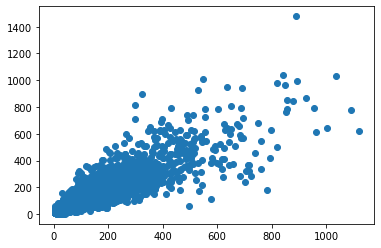

In [63]:
import matplotlib.pyplot as plt
plt.scatter(shapes[:,0],shapes[:,1])

In [5]:
! nvidia-smi

Thu Oct 22 11:36:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   57C    P0   243W / 250W |   9191MiB / 32510MiB |     93%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [9]:
dict(zip(y,y2))

0_run.sh			    checkpoints		orig_test_set_matlab
1_data_assemble.ipynb		    checkpoints_class1	out_dir
1_run.sh			    checkpoints_class2	predictions_class1.pkl
2_train_model.ipynb		    checkpoints_class3	predictions_class2.pkl
3_new_dataset_do_over.ipynb	    checkpoints_class4	predictions_class3.pkl
4_bert_total.ipynb		    class1.out		predictions_class4.pkl
4_calibration_curve.ipynb	    class2.out		prelim_out_dir
5_WSI_RIM_Tabulation.ipynb	    class3.out		prelim_out_dir_old
5_WSI_RIM_Tabulation.py		    class4.out		prelim_out_dir_old2
6_investigate_atypia_slides.ipynb   example_full_scans	segmentation_practice
7_sanity_check_matlab.ipynb	    images		tmp_test.pkl
8_sanity_check_dzi.py		    inputs		torque_job.sh
8_sanity_check_slide_overlay.ipynb  nohup.out		webapp_images
HE2Tri				    old			webapp_images_dzi
PathPretrain			    orig_pngs.zip


In [64]:
from sklearn.model_selection import train_test_split
cut_small=True
if not cut_small:
    include_image=np.logical_and(shapes[:,0]>=4, shapes[:,1]>=4, np.logical_or(shapes[:,0]>=10,shapes[:,1]>=10))
    X,y2=X.loc[include_image],y2[include_image]
X_train,X_test,y_train,y_test=train_test_split(X,y2,train_size=0.8,stratify=y2,random_state=42)
X_train,X_test=X_train.tolist(),X_test.tolist()

In [10]:
! mkdir inputs_new

In [65]:
pickle.dump(dict(X=X_train,y=y_train),open('inputs_new/train_data.pkl','wb'))
pickle.dump(dict(X=X_test,y=y_test),open('inputs_new/val_data.pkl','wb'))

In [16]:
# ! mkdir inputs

In [17]:
! git clone https://github.com/jlevy44/PathPretrain

Cloning into 'PathPretrain'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 70 (delta 41), reused 51 (delta 22), pack-reused 0
Unpacking objects: 100% (70/70), done.


In [34]:
# X_train[:2]
"""{'leukocytes': 3,
 'neg': 4,
 'squamous': 6,
 'aty': 0,
 'rbc': 5,
 'debris': 2,
 'crystal': 1}"""
# classifier 1 -> squam, neg aty vs RBC/leuk vs deb/cryst --label_map {6:0,4:0,0:0,5:1,3:1,2:2,1:2} --num_classes 3
# classifier 2 -> squam vs neg aty --label_map {6:0,4:1,0:1} --num_classes 2
# classifier 3 -> neg vs aty --label_map {4:0,0:1} --num_classes 2